In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [22]:
base_dir = "/eos/home-d/dmapelli/public/latino/"

plot_config  = "Full2018v6s5"
cut     = "boos_sig_mjjincl"
#cut     = "res_sig_mjjincl"
version = "v10"

samples_dir = os.path.join(base_dir, plot_config, cut, "samples/" + version)

In [23]:
samples_dir

'/eos/home-d/dmapelli/public/latino/Full2018v6s5/boos_sig_mjjincl/samples/v10'

In [24]:
classes = { "VBS": 0, "Wjets":1, "top": 2, "DY": 3, "VV":4, "VBF-V":5}
signal = "VBS"
sample_names = ["Wjets", "VBS", "DY", "top", "VV", "VBF-V"]

samples = {}

for file in os.listdir(samples_dir):
    if os.path.isdir(os.path.join(samples_dir, file)): continue
    print(file)    
    sname = file.split("_part")[0]
    s = pickle.load(open(os.path.join(samples_dir, file), "rb"))
    s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
    s["sample_name"]= sname
    s["class"] = classes[sname]
    if sname == signal:
        s["signal"] = 1
    else: 
        s["signal"] = 0
    if sname in samples:
        samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
    else:
        samples[sname] = s

DY_part1.pkl
DY_part2.pkl
DY_part3.pkl
VBF-V_part1.pkl
VBS_part1.pkl
VV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
top_part1.pkl


In [25]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight_).sum()*41.5 :15}")

Sample name DY        , nsamples:      27329,   XS total: 651.4729512361292
Sample name VBF-V     , nsamples:        547,   XS total: 197.13588565727758
Sample name VBS       , nsamples:      22786,   XS total: 114.20891419060126
Sample name VV        , nsamples:      12679,   XS total: 185.9614064646165
Sample name Wjets     , nsamples:      95970,   XS total: 6760.780788193464
Sample name top       , nsamples:      15681,   XS total: 1385.0097446945354


In [28]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.preprocessing import LabelEncoder 

## Balancing

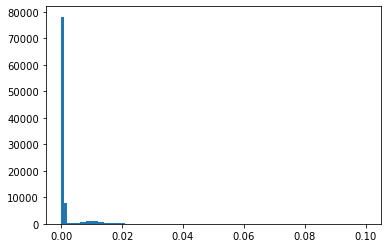

In [29]:
_ = plt.hist(samples["Wjets"]["weight_"], bins=100, range=(0,0.1))


In [30]:
# _ = plt.hist(samples["top"].XSWeight*130, bins=100, range=(0,1))
#plt.xscale("log")

In [31]:
# _ = plt.hist(samples["DY"].XSWeight*130, bins=100, range=(0,1))

In [32]:
# _ = plt.hist(samples["VBS"].XSWeight*(1/samples["VBS"].XSWeight.mean()), bins=100, range=(0,2))

In [33]:
# _= plt.hist( samples["Wjets"].XSWeight*1000, bins=100, range=(0, 2))

In [34]:
# _= plt.hist( (background.XSWeight *(1/ background.XSWeight.mean()))*10  , bins=100, range=(0, 10))

In [35]:
background = pd.concat([
                samples["top"],
                samples["DY"],
                samples["Wjets"],
                samples["VV"],
                samples["VBF-V"]
                ], ignore_index=True)

In [36]:
signal = samples["VBS"]

In [37]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

6.679803388045291


In [38]:
tot_ev_weighted_sig = (signal.weight_ / signal.weight_.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

TOT signal weighted events 22786.0


In [39]:
rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.weight_.sum()
print(rescale_factor_bkg)

688.0501925745587


In [40]:
signal["weight_norm"] = signal.weight_ / signal.weight_.mean()
background["weight_norm"] = background.weight_ * rescale_factor_bkg

## Save signal and bkg samples

In [41]:
import os

os.makedirs(os.path.join(samples_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"), "wb"))

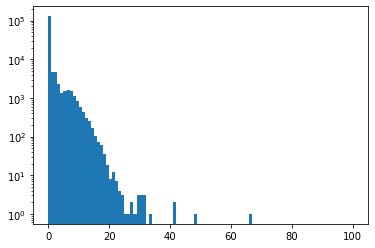

In [42]:
plt.hist(background["weight_norm"], bins=100, range=(0, 100))
plt.yscale("log")

The total number of events will be manually balanced